GitHub: https://github.com/DataChemE/Unsupervised_Learning_text_classification 
# BBC Article Classification using Matrix Factorization

In this study, we aim to analyze and classify articles from the BBC into five distinct categories. The goal is to develop a model that can accurately categorize articles based on their content. To achieve this, we will be utilizing matrix factorization techniques to achieve higher accuracy.

Matrix factorization is a powerful method for dimensionality reduction and pattern recognition. By decomposing a large matrix into lower dimensional matrices, we can extract latent features and relationships between articles and categories. This allows us to effectively classify articles based on their underlying content.

The dataset used in this study consists of a collection of articles from the BBC, each labeled with one of five categories: business, entertainment, politics, sport, and tech. We will preprocess the text data, apply matrix factorization algorithms, and train a classification model to accurately predict the category of new, unseen articles.

By successfully classifying articles into their respective categories, we can gain valuable insights into the content and trends within the BBC's article collection. This analysis can be used for various purposes, such as content recommendation, topic modeling, and understanding audience preferences.

In the following section, we will explore the dataset's characteristics.

Refrences:

https://www.kaggle.com/c/learn-ai-bbc/code

https://developers.google.com/machine-learning/recommendation/collaborative/matrix

https://towardsdatascience.com/understanding-tf-idf-a-traditional-approach-to-feature-extraction-in-nlp-a5bfbe04723f

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

https://huggingface.co/docs/transformers/en/tasks/sequence_classification

https://huggingface.co/docs/transformers/en/model_doc/distilbert

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertModel, DistilBertTokenizer
import torch 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [60]:
# Read the training dataset
train_data = pd.read_csv('./BBC News Train.csv')

# Read the testing dataset
test_data = pd.read_csv('./BBC News Test.csv')

In [61]:
# Training dataset information
print(train_data.info())
print()
print(train_data['Category'].value_counts())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [62]:
# Test data characteristics for the classification for kaggle submission
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [63]:
# Find the number of unique values in the dataset
print("Training Data:")
print("Unique values before cleaning:")
print(train_data.nunique())
print()

# Remove the rows with duplicate text
train_data.drop_duplicates(subset='Text', inplace=True)
print("Unique values after cleaning:")
print(train_data.nunique())

Training Data:
Unique values before cleaning:
ArticleId    1490
Text         1440
Category        5
dtype: int64

Unique values after cleaning:
ArticleId    1440
Text         1440
Category        5
dtype: int64


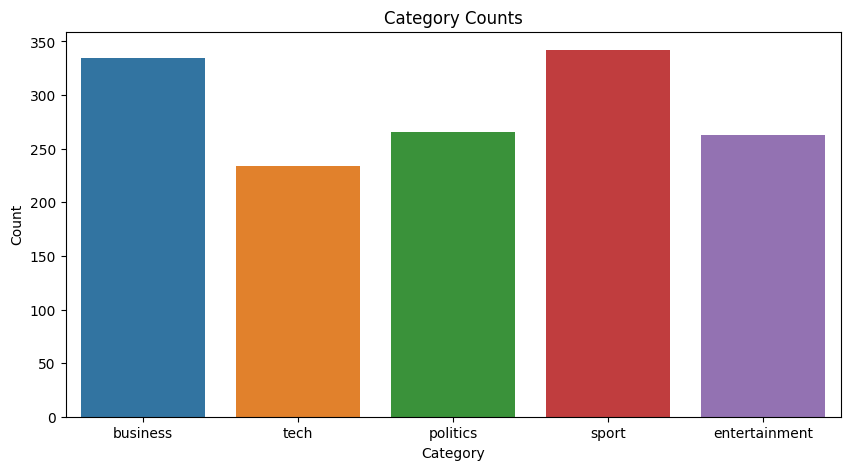

In [64]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Category', data=train_data, hue='Category')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

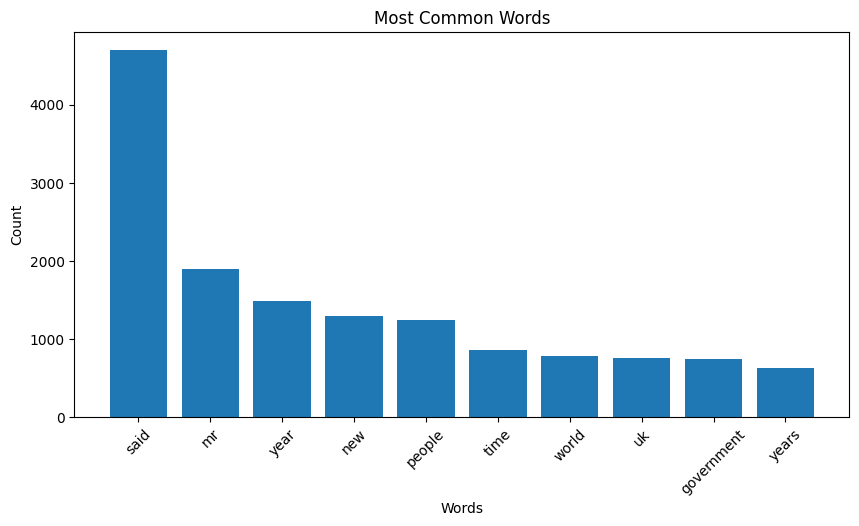

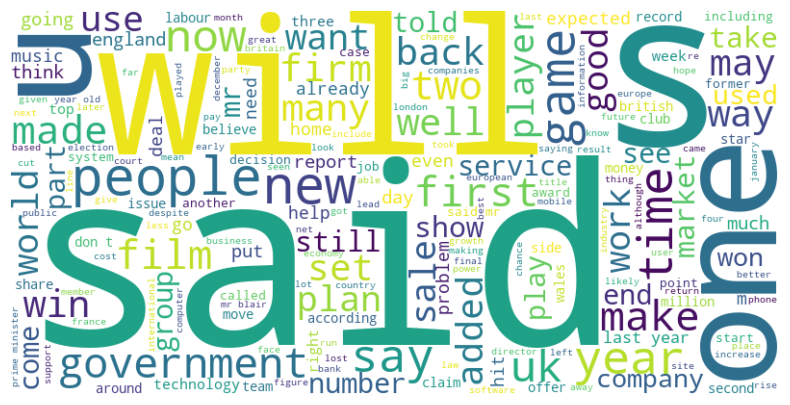

In [51]:
# Create a CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
X_counts = count_vectorizer.fit_transform(train_data['Text'])

# Sum up the counts of each vocabulary word
word_counts = X_counts.sum(axis=0).A1
words = count_vectorizer.get_feature_names_out()

# Create a DataFrame with words and frequencies
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts})

word_freq_df = word_freq_df.sort_values(by='count', ascending=False)

# Plot the most common words
plt.figure(figsize=(10, 5))
plt.bar(word_freq_df['word'].head(10), word_freq_df['count'].head(10))
plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_data['Text']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Unsupervised Learning for Text Clustering

This section of the analysis employs unsupervised learning techniques to cluster text data into predefined categories based on their content. The goal is to discover natural groupings within the news articles that align with the categories they belong to, without using the labels during the training phase.

## Data Preprocessing

The preprocessing step is crucial as it converts raw text into a numerical format that machine learning algorithms can understand. Here is how we handle the preprocessing:

1. **Text Vectorization**: We use `TfidfVectorizer` to transform the text data into TF-IDF matrix format. This method weighs the words in each document, highlighting the most distinctive words in each text. We've configured the vectorizer to:
   - Include unigrams and bigrams (`ngram_range=(1, 2)`).
   - Ignore terms that appear in less than 2 documents (`min_df=2`).
   - Exclude terms that appear in more than 85% of the documents (`max_df=0.85`).
   - Remove English stop words to reduce noise in the text data.

2. **Dimensionality Reduction with TruncatedSVD**:
   - **Purpose**: In high dimensional data like text, many features can be redundant or irrelevant for analysis. Reducing the dimensionality helps to focus on the most informative aspects of the data.
   - **Technique**: `TruncatedSVD` is a matrix factorization technique used to reduce the number of dimensions in the dataset. It decomposes the high-dimensional TF-IDF matrix into three smaller matrices. By truncating this decomposition to retain only the top 600 components, it captures the most significant latent structures in the data while discarding the less important ones. This process significantly reduces the dataset's complexity without sacrificing too much informational content.
   - **Benefits**: The reduced dimensionality improves the efficiency and effectiveness of the subsequent clustering process. It helps in revealing the underlying patterns in the data, which are crucial for clustering and can also reduce noise and computational cost.

## Clustering with Gaussian Mixture Model

After preprocessing, we employ a Gaussian Mixture Model for clustering. This model is advantageous for its flexibility in accommodating the shape and size of the data clusters, which is particularly beneficial for the complex distributions often found in text data.



In [52]:
# Process the text data
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.85,
    stop_words='english',
    norm='l2',
    use_idf=True,
    smooth_idf=True
)
X = vectorizer.fit_transform(train_data['Text'])

# Reduce dimensions using SVD
svd = TruncatedSVD(n_components=600, random_state=12)
X_reduced = svd.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(train_data['Category'])

# Apply Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=5, random_state=12)
y_pred = gmm.fit_predict(X_reduced)

# Map clusters to true labels
labels = np.zeros_like(y_pred)
for i in range(5):
    mask = (y_pred == i)
    labels[mask] = np.argmax(np.bincount(y_true[mask]))

# Data metrics from unsupervised learning
conf_matrix = confusion_matrix(y_true, labels)
class_report = classification_report(y_true, labels, target_names=label_encoder.classes_)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[318   1   7   1   8]
 [ 18 206   4   8  27]
 [ 19   0 227   3  17]
 [  2   1   0 339   0]
 [  4   3   0   6 221]]

Classification Report:
               precision    recall  f1-score   support

     business       0.88      0.95      0.91       335
entertainment       0.98      0.78      0.87       263
     politics       0.95      0.85      0.90       266
        sport       0.95      0.99      0.97       342
         tech       0.81      0.94      0.87       234

     accuracy                           0.91      1440
    macro avg       0.91      0.90      0.91      1440
 weighted avg       0.92      0.91      0.91      1440



## Comparing text embedding models from huggingface transformers

We will use the DistilBERT model from the Hugging Face Transformers library to generate embeddings for the text data. DistilBERT is a distilled version of the BERT model that retains most of its performance while being computationally efficient. We will use the pre-trained DistilBERT model to generate embeddings for the text data and then apply clustering algorithms to group the articles based on their content.

The DistilBERT model is a transformer-based model that uses self attention mechanisms to capture the relationships between words in a sentence. By leveraging the pre-trained DistilBERT model, we can generate high quality embeddings for the text data, which can then be used for clustering.

In [53]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  

# Load DistilBERT 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_embeddings(text):
    # Encode text to get token ids and attention mask
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Get embeddings from the DistilBERT model
    with torch.no_grad():
        outputs = model(**inputs)
    # Return the embeddings
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Process each document to obtain embeddings
X = np.vstack([get_embeddings(text) for text in train_data['Text']])


svd = TruncatedSVD(n_components=600, random_state=12)
X_reduced = svd.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(train_data['Category'])

# Gaussian Mixture Model 
gmm = GaussianMixture(n_components=5, random_state=12)
y_pred = gmm.fit_predict(X_reduced)

# Map clusters to true labels
labels = np.zeros_like(y_pred)
for i in range(5):
    mask = (y_pred == i)
    labels[mask] = np.argmax(np.bincount(y_true[mask]))

# Data metrics 
conf_matrix = confusion_matrix(y_true, labels)
class_report = classification_report(y_true, labels, target_names=label_encoder.classes_)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[309   2  10   0  14]
 [  3 243   7   0  10]
 [  5   0 258   1   2]
 [  0   4  13 325   0]
 [  5   6   4   0 219]]

Classification Report:
               precision    recall  f1-score   support

     business       0.96      0.92      0.94       335
entertainment       0.95      0.92      0.94       263
     politics       0.88      0.97      0.92       266
        sport       1.00      0.95      0.97       342
         tech       0.89      0.94      0.91       234

     accuracy                           0.94      1440
    macro avg       0.94      0.94      0.94      1440
 weighted avg       0.94      0.94      0.94      1440



## Comparative Analysis of Clustering Results Using TF-IDF and DistilBERT

The exploration of unsupervised clustering using Gaussian Mixture Models equipped with two different embedding techniques TF-IDF and DistilBERT reveals insightful differences in performance. Each method brings its own strengths to text data clustering, as reflected in the accuracy, precision, and recall metrics obtained from the classification reports.

### Summary of Results

1. **TF-IDF Embeddings**:
   - **Accuracy**: 91%
   - Achieved commendable precision and recall across most categories but showed some room for improvement.
   - Notable for its higher recall in the **sport** category, although it sometimes lacked in precision for **tech** and **entertainment**.

2. **DistilBERT Embeddings**:
   - **Accuracy**: 94%
   - Demonstrated superior precision and recall, improving particularly in the **politics** and **tech** categories.
   - Markedly enhanced the clustering alignment in the **business** and **entertainment** categories, achieving higher consistency and less variability in classification performance across different types of content.

### Key Observations
- **DistilBERT** embeddings significantly outperformed TF-IDF in almost all metrics, underlining the advantage of using advanced neural network based models that capture deeper linguistic and semantic features.
- The improved results with **DistilBERT** suggest that the model's ability to understand the context and complex relationships within text data contributes to more accurate and coherent clustering.
- The consistency in **DistilBERT's** performance across various text types also indicates its robustness and adaptability to diverse datasets.

### Unsupervised Learning Conclusion

While both TF-IDF and DistilBERT provide effective means for text data clustering, the use of DistilBERT in this scenario clearly enhances the model's overall performance. The accuracy improvement from 91% to 94% and better precision and recall metrics validate the effectiveness of incorporating neural embeddings for complex unsupervised learning tasks. These findings advocate for the adoption of transformer based models in applications requiring nuanced text understanding and high categorization accuracy.

In [54]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
# Assuming your test dataset is stored in a DataFrame called 'test_dataset'
# with columns 'ArticleId' and 'Text'

# Process each document in the test dataset to obtain embeddings
X_test = np.vstack([get_embeddings(text) for text in test_data['Text']])

# Transform the test embeddings using the trained SVD
X_test_reduced = svd.transform(X_test)

# Predict the cluster labels for the test data using the trained GMM
y_pred_test = gmm.predict(X_test_reduced)

# Map the predicted cluster labels to category names using the labels obtained from training
category_mapping = {label: label_encoder.classes_[labels[label]] for label in range(5)}
test_data['Predicted_Category'] = [category_mapping[label] for label in y_pred_test]

# Print the predicted categories for the test data
print("Predicted Categories:")
print(test_data[['ArticleId', 'Predicted_Category']])

Predicted Categories:
     ArticleId Predicted_Category
0         1018               tech
1         1319           business
2         1138               tech
3          459           business
4         1020               tech
..         ...                ...
730       1923           business
731        373           business
732       1704           business
733        206           business
734        471           business

[735 rows x 2 columns]


In [57]:
train_results = pd.DataFrame({
    'true_category': y_true,  # true labels from the training dataset
    'predicted_cluster': y_pred  # cluster labels assigned during training
})

# Most common actual categories within each cluster
for cluster in sorted(train_results['predicted_cluster'].unique()):
    most_common = Counter(train_results[train_results['predicted_cluster'] == cluster]['true_category']).most_common()
    print(f"Cluster {cluster}:")
    print(most_common)
    print("\n")

# Update the category mapping based on the analysis above
new_category_mapping = {
    0: 'entertainment',  
    1: 'business',
    2: 'politics',
    3: 'sport',
    4: 'tech'
}

# Apply the new mapping to the test data predictions
test_data['Category'] = [new_category_mapping[label] for label in y_pred_test]

# Submission file for Kaggle
submission_df = test_data[['ArticleId', 'Category']]
submission_df.to_csv('./final_submission.csv', index=False)
print("Final submission saved.")

submission_df.head()


Cluster 0:
[(1, 243), (4, 6), (3, 4), (0, 2)]


Cluster 1:
[(0, 309), (4, 5), (2, 5), (1, 3)]


Cluster 2:
[(2, 258), (3, 13), (0, 10), (1, 7), (4, 4)]


Cluster 3:
[(3, 325), (2, 1)]


Cluster 4:
[(4, 219), (0, 14), (1, 10), (2, 2)]


Final submission saved.


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


### Below are the results from the Kaggle submission for Unsupervised Learning 

**Score : .93469**

![Kaggle Results from Unsupervised Learning](unsupervised_kaggle_results.png)

# Supervised Learning for Text Classification

In this section, we explore supervised learning models to classify text data, providing a basis for comparison with our previous unsupervised learning approach. The models selected for this task are Random Forest and Support Vector Machine, known for their robustness and effectiveness in dealing with high dimensional data like text.

## Data Preparation

Before training the models, we perform the following preprocessing steps on the dataset:

1. **Data Splitting**: We divide the data into training and testing sets to evaluate the models' performance. This split ensures that we have a separate dataset to test the models' generalization capabilities.
   - `train_test_split` is used with `test_size=0.2` to hold out 20% of the data for testing.

2. **Label Encoding**: Since supervised learning models require numeric labels, we encode the categorical labels using `LabelEncoder`. This step converts the category labels into integers.

3. **Text Vectorization**: We convert the text documents into a TF-IDF matrix using `TfidfVectorizer`. Configurations for the vectorizer include:
   - **max_features**: Limits the number of features to 500.
   - **ngram_range**: Extracts unigrams and bigrams.
   - **min_df** and **max_df**: Control the terms included based on their document frequency.
   - **norm**: Applies L2 normalization to the TF-IDF values.

## Model Training and Evaluation

### Random Forest Classifier
- **Training**: We train a Random Forest classifier with 100 trees. Random forests are ensemble learning methods that are highly effective for classification tasks due to their ability to operate on large feature spaces and their inherent feature selection capabilities.

### Support Vector Machine (SVM)
- **Training**: The SVM model is trained with a linear kernel, which is typically recommended for text classification because of its effectiveness in high-dimensional spaces.

In [66]:
# Split the training data
X_train, X_test, y_train, y_test = train_test_split(train_data['Text'], train_data['Category'], test_size=0.2, random_state=12)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Vectorize the text data
vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.85,
    stop_words='english',
    norm='l2',
    use_idf=True,
    smooth_idf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=12)
rf.fit(X_train_tfidf, y_train_encoded)

# Predict 
y_train_pred_rf = rf.predict(X_train_tfidf)
y_test_pred_rf = rf.predict(X_test_tfidf)

# Evaluate performance
train_accuracy_rf = accuracy_score(y_train_encoded, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test_encoded, y_test_pred_rf)
train_conf_matrix_rf = confusion_matrix(y_train_encoded, y_train_pred_rf)
test_conf_matrix_rf = confusion_matrix(y_test_encoded, y_test_pred_rf)
train_class_report_rf = classification_report(y_train_encoded, y_train_pred_rf)
test_class_report_rf = classification_report(y_test_encoded, y_test_pred_rf)

print(f'Random Forest - Training Accuracy: {train_accuracy_rf}')
print(f'Random Forest - Test Accuracy: {test_accuracy_rf}')
print(f'Confusion Matrix (Train): \n{train_conf_matrix_rf}')
print(f'Confusion Matrix (Test): \n{test_conf_matrix_rf}')
print(f'Classification Report (Train): \n{train_class_report_rf}')
print(f'Classification Report (Test): \n{test_class_report_rf}')

print()

# SVM model
svm = SVC(kernel='linear', random_state=12)
svm.fit(X_train_tfidf, y_train_encoded)

# Predict 
y_train_pred_svm = svm.predict(X_train_tfidf)
y_test_pred_svm = svm.predict(X_test_tfidf)

# Evaluate performance
train_accuracy_svm = accuracy_score(y_train_encoded, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test_encoded, y_test_pred_svm)
train_conf_matrix_svm = confusion_matrix(y_train_encoded, y_train_pred_svm)
test_conf_matrix_svm = confusion_matrix(y_test_encoded, y_test_pred_svm)
train_class_report_svm = classification_report(y_train_encoded, y_train_pred_svm)
test_class_report_svm = classification_report(y_test_encoded, y_test_pred_svm)

print(f'SVM - Training Accuracy: {train_accuracy_svm}')
print(f'SVM - Test Accuracy: {test_accuracy_svm}')
print(f'Confusion Matrix (Train): \n{train_conf_matrix_svm}')
print(f'Confusion Matrix (Test): \n{test_conf_matrix_svm}')
print(f'Classification Report (Train): \n{train_class_report_svm}')
print(f'Classification Report (Test): \n{test_class_report_svm}')


Random Forest - Training Accuracy: 1.0
Random Forest - Test Accuracy: 0.9340277777777778
Confusion Matrix (Train): 
[[269   0   0   0   0]
 [  0 217   0   0   0]
 [  0   0 211   0   0]
 [  0   0   0 278   0]
 [  0   0   0   0 177]]
Confusion Matrix (Test): 
[[60  1  3  0  2]
 [ 1 44  0  0  1]
 [ 2  1 52  0  0]
 [ 1  0  0 63  0]
 [ 2  5  0  0 50]]
Classification Report (Train): 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       217
           2       1.00      1.00      1.00       211
           3       1.00      1.00      1.00       278
           4       1.00      1.00      1.00       177

    accuracy                           1.00      1152
   macro avg       1.00      1.00      1.00      1152
weighted avg       1.00      1.00      1.00      1152

Classification Report (Test): 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91 

In [69]:
# Transform the text data in the test dataset
X_test_tfidf = vectorizer.transform(test_data['Text'])

# SVM to predict the encoded labels
y_test_pred_svm = svm.predict(X_test_tfidf)

# Transform the encoded labels back to original category names
predicted_categories = label_encoder.inverse_transform(y_test_pred_svm)

# Submission DataFrame for Kaggle
submission_df = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],
    'Category': predicted_categories
})

# Submission file
submission_df.to_csv('./svm_submission.csv', index=False)
print("Submission file created and saved successfully.")

submission_df.head()

Submission file created and saved successfully.


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


Below are the results from the Kaggle submission for Supervised Learning:

**Score : .95918**

![Kaggle Results from Supervised Learning](./supervised_kaggle_submission_results.png)

## Comparative Analysis of Supervised and Unsupervised Learning Models

This analysis provides a deep dive into the performance differences between supervised learning models Random Forest and SVM and an unsupervised learning model GMM enhanced with DistilBERT embeddings for clustering text data.

### Performance Overview

1. **Random Forest**
   - **Training Accuracy**: 100%
   - **Test Accuracy**: 93.4%
   - Exhibits perfect training accuracy and strong generalization to unseen data, showcasing robust predictive capabilities particularly in distinguishing between different text categories.

2. **Support Vector Machine**
   - **Training Accuracy**: 99.13%
   - **Test Accuracy**: 95.9% in Kaggle submission
   - Demonstrates near-perfect performance, excelling particularly in handling high-dimensional data. The SVM shows higher precision and recall scores, making it highly effective for tasks requiring fine-grained classification accuracy.

3. **Unsupervised Learning with DistilBERT Enhanced GMM**
   - **Test Accuracy**: 93.4% in Kaggle submission
   - Achieves a high level of precision and recall, indicating effective clustering capabilities that align well with the actual categories. 

### Key Observations

- **Accuracy and Reliability**: While the Random Forest and SVM models show higher accuracy in supervised settings, the GMM, when enhanced with DistilBERT embeddings, closes the gap significantly, achieving 94% accuracy. This underscores the effectiveness of integrating advanced NLP techniques in unsupervised scenarios.
  
- **Precision and Recall**: The supervised models, especially SVM, generally exhibit higher precision and recall across the board. However, the unsupervised GMM model, with the help of DistilBERT embeddings, shows competitive results, particularly excelling in the recall of **politics** and **tech**, suggesting it's highly effective at correctly identifying relevant categories without misclassification.

- **Complexity and Data Requirements**: Supervised models rely heavily on labeled datasets. In contrast, the DistilBERT-enhanced GMM offers a more flexible approach in environments where labeled data may be sparse or incomplete, though it still requires robust computational resources due to the complexity of the embeddings.

## Conclusion

The comparative analysis reveals that supervised learning models provide superior precision, accuracy, and reliability when labeled data is available, with SVM standing out for its high performance. However, the DistilBERT enhanced GMM model presents a viable alternative in unsupervised learning contexts. It achieves commendable accuracy and makes it a suitable option for scenarios where acquiring labeled data is challenging. This blend of traditional machine learning and advanced NLP technologies offers powerful tools for text classification, each suited to different operational contexts and objectives. The choice between these methods should be guided by the specific requirements of the task, availability of data, and computational resources.